# Monte Carlo Simulation

Today, we will work with the Lennard Jones equation.

$$ U(r) = 4 \epsilon \left[\left(\frac{\sigma}{r}\right)^{12} -\left(\frac{\sigma}{r}\right)^{6} \right] $$ 
Reduced units:
$$ U^*\left(r^*_{ij} \right) = 4 \left[\left(\frac{1}{r^*_{ij}}\right)^{12} -\left(\frac{1}{r^*_{ij}}\right)^{6} \right] $$ 

In [1]:
import math, os, random
import matplotlib.pyplot as plt

%matplotlib notebook

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.
    
    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced unites.
    
    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
        
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.
    
    """
    
    r6_term = math.pow(1/r_ij,6)
    r12_term = math.pow(r6_term,2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

In [2]:
# Make tests for the function - ESSENTIAL
calculate_LJ(1)

0.0

In [3]:
calculate_LJ(math.pow(2,(1/6)))

-1.0

In [4]:
assert 1 == 1

In [5]:
# If we assert something that is not True (otherwise known as False), we will get an assert error
assert 1 == 0

AssertionError: 

In [6]:
assert calculate_LJ(1) == 0
assert calculate_LJ(math.pow(2,(1/6))) == -1

In [7]:
# docstring - documentation string
def calculate_distance(coord1,coord2,box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2 : list
        The atomic coordinates [x, y, z]
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
    
    Returns
    -------
    distance : float
        The distance between the two atoms.
    """
    distance = 0
    vector = [0,0,0]
    for i in range(3):
        vector[i] = coord1[i] -coord2[i]
        if box_length is None:
            pass
        else:
            if vector[i] > box_length/2:
                vector[i] -= box_length
            elif vector[i] < -box_length/2:
                vector[i] += box_length
        dim_dist = vector[i] ** 2
        
        # if box_length:
        #     
        distance += dim_dist
    distance = math.sqrt(distance)
    return distance

In [8]:
point_1 = [0,0,0]
point_2 = [1,0,0]
dist1 = calculate_distance(point_1,point_2)
assert dist1 == 1

point_3 = [0,0,0]
point_4 = [0,1,1]

dist2 = calculate_distance(point_3,point_4)
assert dist2 == math.sqrt(2)

In [9]:
atomic_coordinates = [[0, 0, 0], [0, math.pow(2, 1/6), 0], [0, 2*math.pow(2, 1/6), 0]]

In [10]:
def calculate_total_energy(coordinates, cutoff=3, box_length=None):
    """
    Calculate the total Lennard Jones energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    cutoff : float
        A criteria distance for intermolecular interaction truncation
    
    box_length : float, optional
        The box length. This function assumes box is a cube.
        
    Returns
    -------
    total_energy : float
        The total pairwise Lennard Jones energy of the system of particles.
    """
    
    total_energy = 0
    
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1,num_atoms):
            
            # print(F'Comparing atom number {i} with atom number {j}')
            
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)
            
            if dist_ij < cutoff:
                interaction_energy = calculate_LJ(dist_ij)
                total_energy += interaction_energy
            
    return total_energy

In [11]:
calculate_total_energy(atomic_coordinates, box_length=10)

-2.031005859375

In [12]:
def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

In [13]:
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')

coordinates, box_length = read_xyz(file_path)

In [14]:
box_length

10.0

In [15]:
len(coordinates)

800

In [16]:
calculate_total_energy(coordinates, box_length=10)

-4351.540194543858

# Tail Correction

Truncating interactions using a cutoff removes contribution to the potential energy that might be non-negligible. The tail correction for our system makes a correction for use of the cutoff. We only have to calculate this once at the start of our simulation. The formula is:

$$U_{tail} = \frac{8\pi N^2}{3V} \epsilon \sigma ^3 \left[\frac{1}{3}\left(\frac{\sigma}{r_c}\right)^9 - \left(\frac{\sigma}{r_c}\right)^3\right]$$

In reduced units:

$$U_{tail} = \frac{8\pi N^2}{3V} \left[\frac{1}{3}\left(\frac{1}{r_c}\right)^9 - \left(\frac{1}{r_c}\right)^3\right]$$

In [17]:
def calculate_tail_correction(cutoff, box_length, num_atoms):
    """
    Calculate the tail correction.
    
    Parameters
    ----------
    cutoff : float
        The curoff distance.
        
    box_length : float
        The length of the cell.
       
    num_atoms : int
        Number of atoms in a given system.
       
    Returns
    -------
    tail_co_LJ : float
        A float number that shows the value of tail correction energy for the given system.
    """
    
    tail_co_LJ = 0
    
    coeff = 0
    
    r3 = math.pow(1/cutoff,3)
    r9 = math.pow(r3,3)
    
    coeff = 8 * math.pi * (num_atoms ** 2)/(3 * (box_length ** 3))

    tail_co_LJ = coeff * (r9/3 - r3)
    
    return tail_co_LJ

## Flow of calculations

1. Generate an initial system state 'm'.
2. Choose an atom with uniform probability from state 'm'.
3. Propose a new state 'n' by translating the particle with a uniform random displacement in each direction.
4. Calculate the energy change for the particle.
5. Accept or reject new state.

In [18]:
# Write a for loop
def accept_or_reject(delta_e, beta):
    # beta = 1/temperature
    """
    Accept or reject based on change in energy and temperature.
    """
    
    if delta_e == 0:
        accept = True
    else:
        random_number = random.random()
        p_acc = math.exp(-beta * delta_e)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
    return accept

In [19]:
delta_energy = -1
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [20]:
delta_energy = 0
beta = 1
assert accept_or_reject(delta_energy, beta) is True

In [21]:
random.seed(5)
random.random()

0.6229016948897019

In [22]:
delta_energy = 1
beta = 1
assert accept_or_reject(delta_energy, beta) is True

AssertionError: 

In [23]:
# Unset random seed
random.seed() # without argument

In [24]:
def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of a particle with its environment (all other particles in the system)
    
    Parameters
    ----------
    coordinates : list
        The coordinates for all particles in the system.
        
    i_particle : int
        The particle index for which to calculate the energy.
        
    box_length : float
        The length of the simulation box
    
    cutoff : float
        The simulation cutoff. Beyond this distance, interactions are not calculated.
        
    Returns
    -------
    e_total : float
        The pairwise interaction energy of the i-th particle with all other particles in the system.
        
    """
    
    e_total = 0
    num_atoms = len(coordinates)
    
    for j_particle in range(num_atoms):
        if j_particle != i_particle:
            dist = calculate_distance(coordinates[j_particle],coordinates[i_particle],box_length)
            if dist <= cutoff:
                e_total += calculate_LJ(dist)
    
    return e_total

In [25]:
coordinates = [[0,0,0],[0,0,2**(1/6)],[0,0,2*(2**(1/6))]]
assert calculate_pair_energy(coordinates,1,10,3) == -2
assert calculate_pair_energy(coordinates,0,10,3) == calculate_pair_energy(coordinates,2,10,3)

## Simulation loop

In [34]:
# Parameters
reduced_temperature = 1.5
num_steps = 5000
max_displacement = 0.1
cutoff = 3

# Reporting information
freq = 1000
steps = []
energies = []
all_coordinates = []

# Calculated quantities
beta = 1/reduced_temperature

# Read initial coordinates
file_path = os.path.join('lj_sample_configurations','lj_sample_config_periodic1.txt')
coordinates, box_length = read_xyz(file_path)
num_particles = len(coordinates)

total_energy = calculate_total_energy(coordinates, cutoff, box_length)
total_energy += calculate_tail_correction(cutoff, box_length, num_particles)

for step in range(num_steps):
    
    # I. Randomly pick one of num_particles particles
    random_particle = random.randrange(num_particles) # This is an integer.
    
    # II. Calculate the interaction energy of the selected particle with the system. Store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # III. Generate a random x, y, z displacement range (-max_displacement, max_displacement) - UNIFORM DISTRIBUTION
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # IV. Notify the coordinate of selected particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # V. Calculate the new interaction energy of moved particles. Store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # VI. Calculate energy change and decide if we accept the move.
    delta_energy = proposed_energy - current_energy
    
    accept = accept_or_reject(delta_energy, beta)
    
    # VII. If accept, keep movement. If not revert to old position.
    if accept:
        total_energy += delta_energy # Extremely important
    else:
        # Move is not accepted. Roll back coordinates.
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # VIII. Print the energy at certain intervals.
    if step % freq == 0:
        print(step, total_energy/num_particles)
        steps.append(step)
        energies.append(total_energy/num_particles)
        all_coordinates.append(coordinates)

0 -5.687536347860019
1000 -5.519020383452701
2000 -5.455503537411713
3000 -5.370307468948906
4000 -5.356264358351539


<IPython.core.display.Javascript object>


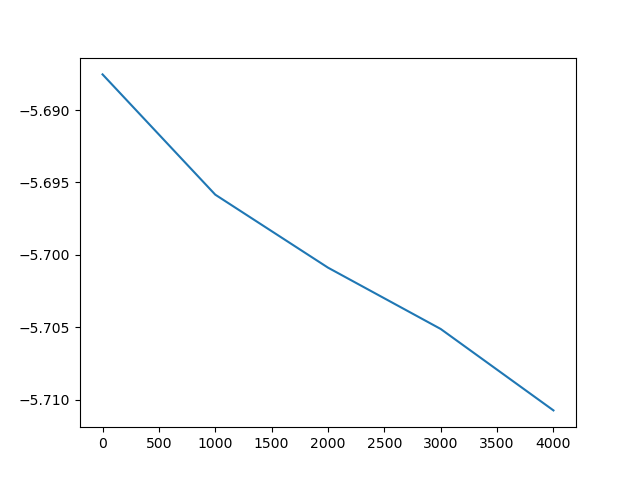

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(steps, energies)